In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,mean_absolute_error
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib.pyplot as plt
from sklearn.tree import export_text
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from dtreeviz.trees import dtreeviz
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image 
import PIL.Image as PilImage
import io
from pydot import graph_from_dot_data
import pandas as pd
import numpy as np
from numpy import nan
from graphviz import render
import seaborn as sns
from matplotlib import pyplot
import matplotlib.ticker as ticker
from chefboost import Chefboost as chef

In [2]:
columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","salary"]

In [3]:
data = pd.read_csv('./data2/adult.data',names=columns,index_col=False)
test = pd.read_csv('./data2/adult.test',names=columns,index_col=False,skiprows=1)

In [4]:
joined_data = pd.concat([data,test])

In [5]:
joined_data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary'],
      dtype='object')

In [6]:
joined_data['relationship'].unique()

array([' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative'], dtype=object)

In [7]:
def min_max_scaling(df,columns):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

In [8]:
columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","salary"]

In [9]:
adult_data = pd.read_csv('./data/adult.data',names=columns,index_col=False)

In [10]:
adult_test = pd.read_csv('./data/adult.test',names=columns,index_col=False,skiprows=1)

In [11]:
joined_data = pd.concat([adult_data,adult_test])

In [12]:
joined_data[columns] = joined_data[columns].replace([' ?','?','? '], nan)
adult_data[columns] = adult_data[columns].replace(' ?',nan)
adult_test[columns] = adult_test[columns].replace(' ?',nan)

In [13]:
joined_data['salary'] = joined_data['salary'].str.strip()
joined_data['salary'] = joined_data['salary'].str.replace(".","")

In [14]:
joined_data['salary'].unique()

array(['<=50K', '>50K'], dtype=object)

In [15]:
joined_data.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
salary               0
dtype: int64

In [ ]:
# joined_data.dropna(inplace=True)
# adult_data.dropna(inplace=True)

#### DISTRIBUTION OF DATA

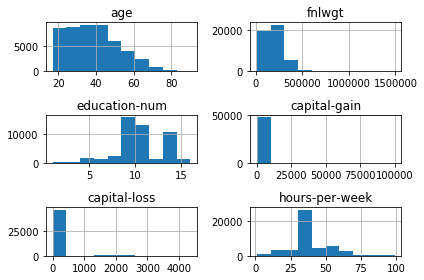

In [16]:
joined_data.hist()
pyplot.tight_layout()
plt.savefig('./figures/distribution.png', bbox_inches='tight', pad_inches=0)
pyplot.show()

### KBinsDiscretizer

In [17]:
discretize_columns = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']

In [18]:
data = joined_data[discretize_columns]

In [19]:
trans = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
data = trans.fit_transform(data)

In [20]:
dataset = pd.DataFrame(data,columns = discretize_columns)

In [21]:
joined_data.update(dataset)

In [22]:
joined_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,3.0,State-gov,0.0,Bachelors,8.0,Never-married,Adm-clerical,Not-in-family,White,Male,0.0,0.0,3.0,United-States,<=50K
1,4.0,Self-emp-not-inc,0.0,Bachelors,8.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,1.0,United-States,<=50K
2,2.0,Private,1.0,HS-grad,5.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,3.0,United-States,<=50K
3,4.0,Private,1.0,11th,4.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,3.0,United-States,<=50K
4,1.0,Private,2.0,Bachelors,8.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,3.0,Cuba,<=50K


In [ ]:
dataset.hist()
pyplot.tight_layout()
plt.savefig('./figures/kbinsdiscretize.png', bbox_inches='tight', pad_inches=0)
pyplot.show()

### UPSAMPLING MINORITY CLASS

In [23]:
joined_data['salary'].value_counts()

<=50K    37155
>50K     11687
Name: salary, dtype: int64

In [24]:
df_majority = joined_data[joined_data.salary=='<=50K']
df_minority = joined_data[joined_data.salary=='>50K']

In [25]:
len(df_majority)

37155

In [26]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123)

In [27]:
joined_data = pd.concat([df_majority, df_minority_upsampled])

In [28]:
joined_data.salary.value_counts()

<=50K    37155
>50K     37155
Name: salary, dtype: int64

### DOWN SAMPLING MAJORITY CLASS

In [ ]:
joined_data['salary'].value_counts()

In [ ]:
df_majority = joined_data[joined_data.salary=='<=50K']
df_minority = joined_data[joined_data.salary=='>50K']

In [ ]:
len(df_majority)

In [ ]:
df_majority_downsampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_minority),    # to match majority class
                                 random_state=123)

In [ ]:
joined_data = pd.concat([df_minority, df_majority_downsampled])

In [ ]:
joined_data.salary.value_counts()

In [ ]:
numerical_columns = joined_data.select_dtypes(include='int64').columns.tolist()
numerical_df = joined_data.select_dtypes(include='int64')
categorical_columns = joined_data.select_dtypes(include='object').columns.tolist()
categorical_columns.remove('salary')

### ONE HOT ENCODING

In [ ]:
joined_data = pd.get_dummies(joined_data,columns=categorical_columns)

In [ ]:
joined_data.head()

In [ ]:
joined_data = pd.get_dummies(joined_data, columns=['salary'],drop_first=True)

In [ ]:
joined_data.dtypes

### NORMALIZE DF

In [ ]:
joined_data = min_max_scaling(joined_data,numerical_columns)

In [ ]:
joined_data.dtypes

### LABEL ENCODING

In [29]:
joined_data.isnull().sum()

age                  0
workclass         3380
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        3390
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country    1328
salary               0
dtype: int64

In [30]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [31]:
joined_data['workclass'] = imputer.fit_transform(joined_data[['workclass']])
joined_data['occupation'] = imputer.fit_transform(joined_data[['workclass']])
joined_data['native-country'] = imputer.fit_transform(joined_data[['workclass']])
relationship = joined_data['relationship']
relationship = relationship.to_frame()
capGain = joined_data['capital-gain']
capGain = capGain.to_frame()
education = joined_data['education']
edu = education.to_frame()

In [32]:
le = preprocessing.LabelEncoder()
enc = preprocessing.OrdinalEncoder()

In [33]:
cols = list(joined_data.select_dtypes(include="object").columns)
print(cols[:-1])

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [34]:
joined_data[cols[:-1]] =enc.fit_transform(joined_data[cols[:-1]])

In [35]:
relationship.rename(columns = {'relationship':'rel_values'}, inplace = True) 
edu.rename(columns = {'education':'ed_values'}, inplace = True) 

In [36]:
relationships = joined_data['relationship'].to_frame()
education = joined_data['education'].to_frame()

In [37]:
new_df = pd.concat([relationships,relationship],axis=1, sort=False)
temp_df = pd.concat([education,edu],axis=1, sort=False)

In [43]:
new_df.value_counts()

relationship  rel_values     
0.0            Husband           38996
1.0            Not-in-family     15448
3.0            Own-child          7827
4.0            Unmarried          5764
5.0            Wife               4642
2.0            Other-relative     1633
dtype: int64

In [38]:
temp_df.value_counts()

education  ed_values    
11.0        HS-grad         21288
15.0        Some-college    15282
9.0         Bachelors       15234
12.0        Masters          5869
8.0         Assoc-voc        3183
7.0         Assoc-acdm       2569
14.0        Prof-school      2161
1.0         11th             2001
0.0         10th             1572
10.0        Doctorate        1544
5.0         7th-8th          1102
6.0         9th               846
2.0         12th              749
4.0         5th-6th           570
3.0         1st-4th           256
13.0        Preschool          84
dtype: int64

In [39]:
unique = new_df.groupby(list(new_df.columns)).size().reset_index(name='Freq')

In [41]:
temp_df['ed_values'].unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Assoc-acdm', ' 7th-8th', ' Some-college', ' Assoc-voc',
       ' 5th-6th', ' 10th', ' 1st-4th', ' Preschool', ' 12th',
       ' Doctorate', ' Prof-school'], dtype=object)

In [ ]:
df = new_df.groupby(['ed_values'])

In [ ]:
temp_df.value_counts()

In [ ]:
joined_data.columns[:-1]

In [ ]:
X = joined_data[joined_data.columns[:-1]]

In [ ]:
y = joined_data['salary']

In [ ]:
X.columns

### PCA

In [ ]:
pca = PCA(n_components =4)
principalComponents = pca.fit_transform(X)

In [ ]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1','pc2','pc3','pc4'])

In [ ]:
#principalDf["Cluster"] = y.tolist()

In [ ]:
principalDf.head()

In [ ]:
df = pd.DataFrame({'variance':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4']})

In [ ]:
ax = plt.axes()
sns.barplot(x='PC',y="variance", 
           data=df, color="c")
ax.set_title('Principle Components')
plt.savefig('./figures/pca.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
# sns.lmplot( x="pc1", y="pc2",
#   data=principalDf, 
#   fit_reg=False, 
#   hue='Cluster', # color by cluster
#   legend=True)

In [ ]:
X = principalDf

### DECISION TREE CLASSIFICATION

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## FEATURE IMPORTANCE

### USING RANDOM FOREST

In [ ]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

In [ ]:
clf.feature_importances_

In [ ]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns.tolist()).sort_values(ascending=False)
feature_impfeature_imp = pd.Series(clf.feature_importances_,index=X_train.columns.tolist()).sort_values(ascending=False)
feature_imp

In [ ]:
X.drop(['workclass','native-country','occupation'],axis=1,inplace=True)

In [ ]:
X.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features")
plt.legend()
plt.savefig('./figures/relationship.png', bbox_inches='tight', pad_inches=0)
plt.show()

### k best

In [ ]:
test = SelectKBest(score_func=f_classif, k=4)

In [ ]:
fit = test.fit(X, y)

In [ ]:
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)

In [ ]:
print(features[0:5,:])

In [ ]:
model = ExtraTreesClassifier(n_estimators=len(columns))
model.fit(X, y)
feature_scores = model.feature_importances_.tolist()
feature_scores.sort(reverse=True)

In [ ]:
# for index,feature in enumerate(feature_scores):
#     print('{}:{}'.format(columns[index], feature))

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
variables = columns
importance = feature_scores
ax.bar(variables,importance)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('feature importance')
plt.show()

In [ ]:
drop_columns=['education_cat','workclass_cat','ms_cat','occupation_cat','relationship_cat','race_cat','sex_cat','native-country_cat']

In [ ]:
X.drop(drop_columns,axis=1)

### OUTLIER DETECTION

In [ ]:
iso = IsolationForest(contamination=0.1)

In [ ]:
yhat = iso.fit_predict(X_train)

In [ ]:
mask = yhat != -1

In [ ]:
X_train, y_train = X_train[mask], y_train[mask]

In [ ]:
y_train

In [ ]:
len(X_train)

### MODEL

In [ ]:
clf = DecisionTreeClassifier(random_state=0,criterion='gini',max_depth=5)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=1)

In [ ]:
n_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [ ]:
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
path = clf.cost_complexity_pruning_path(X_train, y_train)

In [ ]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
len(ccp_alphas)

In [ ]:
model = clf.fit(X_train, y_train)

In [ ]:
model.tree_.max_depth

In [ ]:
tree_rules = export_text(model,feature_names=list(X_train.columns))

In [ ]:
print(tree_rules)

In [ ]:
n_nodes = model.tree_.node_count
n_nodes

### VISUALISE DECISION TREE

In [ ]:
dot_data = StringIO()

In [ ]:
export_graphviz(model, out_file=dot_data, feature_names=X.columns,class_names=list(y_train),rounded = True, 
                precision = 2, filled = True)

In [ ]:
(graph,) = graph_from_dot_data(dot_data.getvalue())

In [ ]:
# plt.figure()
fig = graph.create_png()
Image(graph.create_png())
# im_array = np.asarray(Image(graph.create_png()))
# plt.imshow(Image(graph.create_png()))
# plt.show()
# plt.savefig('./figures/final_tree.png')

In [ ]:
type(fig)

In [ ]:
image = PilImage.open(io.BytesIO(fig))
image.save('./figures/big_tree.png')

### PRUNING TREE

In [ ]:
path = model.cost_complexity_pruning_path(X_train, y_train)

In [ ]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.savefig('./figures/cost_complexity_pruning.png', bbox_inches='tight', pad_inches=0)
plt.show()

### MAX DEPTH

In [ ]:
max_depth = []
acc_gini_train = []
acc_gini_test = []

acc_entropy = []
for i in range(1,50):
    dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini_test.append(accuracy_score(y_test, pred))
    
    
    pred = dtree.predict(X_train)
    acc_gini_train.append(accuracy_score(y_train, pred))
    
    
    ####
    dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
    ####
    max_depth.append(i)
d = pd.DataFrame({'acc_gini_train':pd.Series(acc_gini_train),
 'acc_gini_test':pd.Series(acc_gini_test),
 'acc_entropy':pd.Series(acc_entropy),
 'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini_train', data=d, label='gini_train')
plt.plot('max_depth','acc_gini_test', data=d, label='gini_test')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
# plt.xticks(max_depth)
plt.axvline(x=5, color='r')
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.ylabel('accuracy')
plt.title('Max Depth accuracy')
plt.legend()

### PREDICTIONS

In [ ]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [ ]:
# salary = np.array(y_test).argmax(axis=1)
# predictions = np.array(y_pred).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred.tolist())

In [ ]:
ax = plt.axes()
ax.set_title('normalized confussion matrix')
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues',ax = ax)
plt.savefig('./figures/final_tree_cm.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
print("TRAIN_Accuracy:",accuracy_score(y_train, y_pred_train.tolist()))
print("TRAIN_MSE:",mean_absolute_error(y_train, y_pred_train.tolist()))

print("TEST_Accuracy:",accuracy_score(y_test, y_pred.tolist()))
print("TEST_MSE:",mean_absolute_error(y_test, y_pred.tolist()))